In [4]:
%load_ext autoreload
%autoreload 2

import os
import re
import sys

sys.path.append(os.path.abspath("../"))

import re
from pathlib import Path

import nltk
import pandas as pd
import spacy
from nltk.tokenize import sent_tokenize

# Set display options
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 1000)
pd.set_option("display.max_rows", 400)

from src.data_utils import load_clean_scores
from src.player_utils import PlayerUtil

seasons = ["2023-24"]
df = load_clean_scores(seasons=seasons)
player_util = PlayerUtil(seasons=seasons)

In [5]:
from src.data_utils import PodcastContainer, load_clean_scores
from src.player_utils import PlayerUtil
from src.utils import  get_repo_root

cont = PodcastContainer()
podcast_df = cont.get_podcast_data()
podcast_df.head(10)

,publication_date,file_name,file_path,content,duration
0,2023-10-18 16:25:00+00:00,safest_players_to_draft_favorite_lateround_tar...,G:\My Drive\Columbia\Practical Deep Learning\F...,Welcome into a Wednesday edition of the Fantas...,3911
1,2023-10-19 17:02:00+00:00,players_to_avoid_who_to_take_after_jokic_favor...,G:\My Drive\Columbia\Practical Deep Learning\F...,"Hey, everybody. I'm Doc. He's Rick. We're the ...",3203
2,2023-10-20 16:02:30+00:00,nba_preseason_risers_fallers_202324,G:\My Drive\Columbia\Practical Deep Learning\F...,Welcome to the award winning fantasy basketbal...,1840
3,2023-10-23 21:58:00+00:00,western_conference_win_total_overunder_picks_w...,G:\My Drive\Columbia\Practical Deep Learning\F...,Welcome to the rotor wire fantasy basketball p...,4359
4,2023-10-24 17:38:23+00:00,opening_week_preview_boom_or_bust_players_thre...,G:\My Drive\Columbia\Practical Deep Learning\F...,"Hello, friends, and welcome to the award winni...",2664
5,2023-10-25 16:21:00+00:00,opening_night_takeaways_lebrons_workload_harde...,G:\My Drive\Columbia\Practical Deep Learning\F...,"Welcome to a regular season edition, Brandon K...",3264
6,2023-10-26 17:39:00+00:00,opening_week_fantasy_takeaways_30team_draft_re...,G:\My Drive\Columbia\Practical Deep Learning\F...,"Hey, everybody. Welcome back to the award winn...",3105
7,2023-10-27 17:21:13+00:00,fantasy_basketball_waiver_wire_for_week_2_202324,G:\My Drive\Columbia\Practical Deep Learning\F...,Welcome to the award winning Fantasy Basketbal...,2875
8,2023-10-30 20:55:00+00:00,early_season_takeaways_adds_drops_and_more,G:\My Drive\Columbia\Practical Deep Learning\F...,Welcome to a Monday edition of the rotor wire ...,4197
9,2023-10-31 17:50:00+00:00,james_harden_trade_atlanta_hawks_chatter_with_...,G:\My Drive\Columbia\Practical Deep Learning\F...,"Hey, everybody. I am Steve Alexander, doctor a...",3367


,publication_date,file_name,file_path,content,duration


In [74]:
def contains_name(content) -> bool:
    return "king james" in content.lower()

# podcast_df.content.apply(contains_name)

In [10]:
text = podcast_df.iloc[0].content[:10000]

# List of people to resolve
people = ["LeBron James", "Stephen Curry", "Anthony Davis", "James Harden"]

# Find sentences containing references to each person
for person in people:
    coref_sentences = find_coreferences_for_person(text, person)
    print(f"\nSentences for {person}:")
    for sentence in coref_sentences:
        print(f"  - {sentence}")

NameError: name 'find_coreferences_for_person' is not defined

In [54]:
podcast_df['publication_date'].head(10)

0    2023-10-18 16:25:00+00:00
1    2023-10-19 17:02:00+00:00
2    2023-10-20 16:02:30+00:00
3    2023-10-23 21:58:00+00:00
4    2023-10-24 17:38:23+00:00
5    2023-10-25 16:21:00+00:00
6    2023-10-26 17:39:00+00:00
7    2023-10-27 17:21:13+00:00
8    2023-10-30 20:55:00+00:00
9    2023-10-31 17:50:00+00:00
Name: publication_date, dtype: object

In [51]:
df.game_date.unique()

<DatetimeArray>
['2023-10-24 00:00:00', '2023-10-25 00:00:00', '2023-10-26 00:00:00', '2023-10-27 00:00:00', '2023-10-28 00:00:00', '2023-10-29 00:00:00', '2023-10-30 00:00:00', '2023-10-31 00:00:00', '2023-11-01 00:00:00', '2023-11-02 00:00:00',
 ...
 '2024-04-03 00:00:00', '2024-04-04 00:00:00', '2024-04-05 00:00:00', '2024-04-06 00:00:00', '2024-04-07 00:00:00', '2024-04-09 00:00:00', '2024-04-10 00:00:00', '2024-04-11 00:00:00', '2024-04-12 00:00:00', '2024-04-14 00:00:00']
Length: 160, dtype: datetime64[ns]

In [55]:
row = podcast_df.iloc[0]
pub_date = pd.to_datetime(row.publication_date)
print(pub_date)

2023-10-18 16:25:00+00:00


In [1]:
players = player_util.players_for_date('2023-10-24')
players.head()

NameError: name 'player_util' is not defined

In [83]:
df[df.game_date.dt.date >= pub_date.date()]

,season_year,game_date,gameId,matchup,teamName,teamSlug,personId,personName,minutes,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,freeThrowsAttempted,freeThrowsPercentage,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,fantasyPoints,projectedFantasyPoints,outperformed
392093,2023-24,2023-10-24,22300061,LAL @ DEN,lakers,lakers,2544,lebron james,29.016667,10,16,0.625,1,4,0.250,0,1,0.0,1,7,8,5,1,0,0,1,21,7,40.50,49.35,False
392094,2023-24,2023-10-24,22300061,DEN vs. LAL,nuggets,nuggets,201599,deandre jordan,0.000000,0,0,0.000,0,0,0.000,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00,11.60,False
392095,2023-24,2023-10-24,22300061,DEN vs. LAL,nuggets,nuggets,202704,reggie jackson,24.066667,3,8,0.375,2,5,0.400,0,0,0.0,0,3,3,1,1,0,2,0,8,11,14.25,19.10,False
392096,2023-24,2023-10-24,22300061,LAL @ DEN,lakers,lakers,203076,anthony davis,34.150000,6,17,0.353,1,2,0.500,4,4,1.0,1,7,8,4,0,2,2,3,17,-17,36.00,51.80,False
392097,2023-24,2023-10-24,22300061,DEN vs. LAL,nuggets,nuggets,203200,justin holiday,0.000000,0,0,0.000,0,0,0.000,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.00,8.20,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424473,2023-24,2024-04-14,22301200,POR @ SAC,trail blazers,blazers,1631386,taze moore,30.150000,5,14,0.357,1,5,0.200,1,2,0.5,4,4,8,4,1,0,2,2,12,-27,29.00,1.00,True
424474,2023-24,2024-04-14,22301200,POR @ SAC,trail blazers,blazers,1641712,rayan rupert,40.266667,4,12,0.333,2,7,0.286,1,2,0.5,3,3,6,5,0,0,2,1,11,-25,25.00,15.80,True
424475,2023-24,2024-04-14,22301200,SAC vs. POR,kings,kings,1641732,colby jones,4.283333,3,3,1.000,0,0,0.000,2,2,1.0,0,1,1,1,0,1,0,0,8,1,12.75,7.70,True
424476,2023-24,2024-04-14,22301200,SAC vs. POR,kings,kings,1641771,jalen slawson,3.633333,1,1,1.000,0,0,0.000,0,0,0.0,0,0,0,0,0,0,0,1,2,5,2.00,0.00,True


## RAG

In [17]:
from langchain.chat_models import ChatOpenAI

# Initialize the ChatOpenAI model
llm = ChatOpenAI(
    model="gpt-4",  # Use "gpt-4" or "gpt-3.5-turbo"; replace "gpt-4o-mini" if unsupported
    temperature=0
)

# Podcast text
podcast_text = """
Zion Williamson had an incredible week, showing his usual explosiveness and dominance in the paint. 
However, there were concerns about his injury history, and some analysts discussed whether he could 
sustain this level of play. LeBron James, on the other hand, had his minutes managed as the Lakers 
prepared for the postseason. Laurie Markkanen continued to shine for Utah, displaying impressive scoring 
and rebounding, though some mentioned concerns about his long-term consistency.
"""

# Chat-based input: Messages
messages = [
    {"role": "system", "content": "You are a helpful assistant that summarizes text."},
    {"role": "user", "content": f"Summarize the following text about Zion Williamson:\n{podcast_text}"}
]

# Get the response
response = llm.invoke(messages)

# Print the response content
print(response.content)


Zion Williamson demonstrated exceptional performance this week, despite concerns about his past injuries and doubts about his ability to maintain his current level of play. Meanwhile, LeBron James' playing time was regulated as the Lakers gear up for the postseason. Laurie Markkanen also performed well for Utah, showing notable scoring and rebounding skills, although there are worries about his consistency in the long run.


In [6]:
import faiss
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.llms import OpenAI
from dotenv import load_dotenv
import os
import numpy as np
from langchain.chat_models import ChatOpenAI

load_dotenv()

class PodcastPlayerSummarizer:
    def __init__(self, text, chunk_size=1000, chunk_overlap=200):
        """
        Initialize the podcast summarizer with podcast text.
        
        Args:
            text (str): The podcast text.
            chunk_size (int): Maximum chunk size for splitting the text.
            chunk_overlap (int): Overlap between chunks to preserve context.
        """
        self.text = text
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size, chunk_overlap=chunk_overlap
        )
        self.chunks = self.text_splitter.split_text(text)
        self.embeddings_model = OpenAIEmbeddings()
        self.embeddings = self.embeddings_model.embed_documents(self.chunks)
        self.index = self._create_faiss_index()
        self.llm = ChatOpenAI(
            model="gpt-4o-mini",
            temperature=0
        )

    def _create_faiss_index(self):
        """
        Create a FAISS index for the text chunks.
        """
        # Convert embeddings list to NumPy array with dtype float32
        embeddings_array = np.array(self.embeddings, dtype=np.float32)
    
        # Get the dimension of the embeddings
        dimension = embeddings_array.shape[1]
    
        # Create the FAISS index
        index = faiss.IndexFlatL2(dimension)
        index.add(embeddings_array)  # Add the NumPy array to the index
        return index

    def _retrieve_relevant_chunks(self, query, top_k=5):
        """
        Retrieve the most relevant chunks for a given query.
        
        Args:
            query (str): Query to search the index.
            top_k (int): Number of relevant chunks to retrieve.
        
        Returns:
            list[str]: Relevant text chunks.
        """
        query_embedding = self.embeddings_model.embed_query(query)

        # Convert to NumPy array and ensure 2D shape (1, d)
        query_embedding = np.array(query_embedding, dtype=np.float32).reshape(1, -1)
    
        # Search the FAISS index for the top_k nearest neighbors
        distances, indices = self.index.search(query_embedding, top_k)
    
        # Retrieve the corresponding chunks
        return [self.chunks[i] for i in indices[0]]

    def summarize_player_mentions(self, player_name, top_k=5):
        """
        Summarize mentions of a specific player from the podcast text.
        
        Args:
            player_name (str): The player's name to search for.
            top_k (int): Number of relevant chunks to retrieve.
        
        Returns:
            str: Summary of discussions about the player.
        """
        query = f"Find all mentions and context about {player_name}."
        relevant_chunks = self._retrieve_relevant_chunks(query, top_k=top_k)
        if not relevant_chunks:
            return f"No mentions of {player_name} were found in the podcast."
        
        # Summarize the retrieved chunks using GPT
        context = "\n\n".join(relevant_chunks)
        prompt = (
            f"Summarize the discussions about {player_name} based on the following text:\n\n{context}\n\n"
            f"Provide a concise summary only about {player_name}. If a {player_name} is not mentioned, return 'Is not mentioned in the provided text'"
        )
        
        # TODO whether a player will see more or less playtime in the following game
        # TODO whether a player will be injured or not in the following game
        prompt = (
            f"Evaluate the injury risk of {player_name} based on the following text:\n\n{context}\n\n"
            f"On a scale of 1-10 where 10 is most likely to be out the next game, and 1 is likely to play, 5 is neutral. If a {player_name} is not mentioned, return None"
        )

        messages = [
            {"role": "system", "content": "You are a helpful assistant that summarizes discussions about NBA basketball palyers. "},
            {"role": "user", "content": prompt}
        ]
        response = self.llm.invoke(prompt)
        return response.content

    def summarize_player_mentions_batch(self, player_names, top_k=5):
        """
        Summarize mentions of multiple players in a single batch.
    
        Args:
            player_names (list[str]): List of player names to search for.
            top_k (int): Number of relevant chunks to retrieve for each player.
    
        Returns:
            dict: Player name as the key and their corresponding summary as the value.
        """
        # Retrieve relevant chunks for all players
        all_relevant_chunks = []
        for player_name in player_names:
            query = f"Find all mentions and context about {player_name}."
            relevant_chunks = self._retrieve_relevant_chunks(query, top_k=top_k)
            if not relevant_chunks:
                all_relevant_chunks.append(
                    (player_name, f"No mentions of {player_name} were found")
                )
            else:
                context = "\n\n".join(relevant_chunks)
                all_relevant_chunks.append((player_name, context))

        # Combine all player prompts into a single user message
        # combined_prompt = "Summarize the discussions about the following NBA players based on the provided text.'\n\n"
        combined_prompt = ""
        for player_name, context in all_relevant_chunks:
            combined_prompt += f"Player: {player_name}\nText: {context}\n\n"


        system_prompt = """You are a specialized NBA analyst. Analyze the following text for NBA player mentions and provide a precise, structured analysis.

        Requirements:
        1. Identify all NBA players mentioned (current and former players)
        3. Count total mentions for each player
        4. Analyze whether a player is likely to see increased playing time in upcoming games
        4. Analyze whether a player is likely to outperform or trending upwards in upcoming games
        
        Give the output as a CSV with header.
        """
        # Create a messages list with separate entries for each player
        messages = [
            # {"role": "system", "content": "You are a helpful assistant that summarizes discussions about NBA basketball palyers. If a person is not mentioned, return 'Is not mentioned in the provided text'"},
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": combined_prompt}
        ]
        
        # Call the LLM once for the entire batch
        response = self.llm.invoke(messages)
        return response
        
        # Parse the response by splitting it for each player
        response_text = response.content.strip()
        summaries = {}
        for player_name in player_names:
            # Use player names as markers to extract their summaries
            marker = f"Summary for {player_name}:"
            start_idx = response_text.find(marker)
            if start_idx == -1:
                summaries[player_name] = "No summary found in the response."
                continue
            start_idx += len(marker)
            end_idx = response_text.find("Summary for", start_idx)
            summary = response_text[start_idx:end_idx].strip() if end_idx != -1 else response_text[start_idx:].strip()
            summaries[player_name] = summary
    
        return summaries
        
    def summarize_all_players(self, player_names, top_k=5):
        """
        Summarize discussions for a list of players.
        
        Args:
            player_names (list[str]): List of player names.
            top_k (int): Number of relevant chunks to retrieve for each player.
        
        Returns:
            dict: Player name as the key and summary as the value.
        """
        summaries = {}
        for player in player_names:
            summaries[player] = self.summarize_player_mentions(player, top_k=top_k)
        return summaries


# Load podcast text (replace this with your actual podcast transcription)
podcast_text = """
Zion Williamson had an incredible week, showing his usual explosiveness and dominance in the paint. 
However, there were concerns about his injury history, and some analysts discussed whether he could 
sustain this level of play. LeBron James, on the other hand, had his minutes managed as the Lakers 
prepared for the postseason. Laurie Markkanen continued to shine for Utah, displaying impressive scoring 
and rebounding, though some mentioned concerns about his long-term consistency.
"""

# Player names to search for
player_names = ["Zion Williamson", "LeBron James", "Laurie Markkanen", "Anthony Davis", "Adam Silver", "Paul George", "Kobe Bryant"]

row = podcast_df.iloc[5]
text = row.content

# Initialize the summarizer
summarizer = PodcastPlayerSummarizer(text)

# Get summaries for each player
# summaries = summarizer.summarize_all_players(player_names)
summaries = summarizer.summarize_player_mentions_batch(player_names)

# Print the results
# for player, summary in summaries.items():
#     print(f"Summary for {player}:\n{summary}\n")


C:\Users\Patrick\AppData\Local\Temp\ipykernel_10944\1566523389.py:29: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  self.embeddings_model = OpenAIEmbeddings()
C:\Users\Patrick\AppData\Local\Temp\ipykernel_10944\1566523389.py:32: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  self.llm = ChatOpenAI(


In [8]:
summaries.content

'```csv\nPlayer,Total Mentions,Increased Playing Time Likely,Trending Upwards\nZion Williamson,1,Yes,Yes\nLeBron James,5,Yes,Yes\nAnthony Davis,5,No,No\nLaurie Markkanen,1,Yes,Yes\nAdam Silver,1,No,No\nPaul George,1,No,No\nKobe Bryant,1,No,No\n```'

In [61]:
len(text.split(" "))

11572

In [69]:
# import pickle

# with open('data.pkl', 'wb') as f:
#     pickle.dump(summarizer.index, f)


In [63]:
summarizer.chunks[1]

"State Warriors. But let's start with the LA Lakers. You know, there's a a big outbreak of panic on fantasy basketball Twitter after this game when Darvin Ham said, yeah. You know, we we've kinda want to to to have this plan in place for LeBron James to to have a limited workload during the regular season. He played 29 minutes last night, was notably, like, in and out of the game in in short stints. You know, didn't play a ton, in the first half, especially. And even as the lakers were making a rally, you know, it felt like they were pretty hard line sticking to this stance that LeBron James was not going to play 30 minutes no matter what. Still gives you 21, 8, and 5 with a steal, 10 of 16 from the field. I thought he looked great physically. I will say this. I I don't think LeBron James is going to average under 30 minutes this season. This is like the 8th year in a row that whatever team he's on has said that they're managing his workload. But as we saw last night, when LeBron's off

In [56]:
from langchain_google_vertexai import ChatVertexAI

# Initialize the Vertex AI chat model
llm = ChatVertexAI(model="gemini-1.5-flash-001",temperature=0)
messages = [
    (
        "system",
        "You are a helpful assistant that translates English to French. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]
ai_msg = llm.invoke(messages)
ai_msg

# messages = [
#     ("system", "You are a helpful assistant that answers questions."),
#     ("user", "What is the capital of France?")
# ]

# response_vertexai = vertexai_llm.invoke(messages)
# print("Vertex AI Response:", response_vertexai)

ValueError: tuple.index(x): x not in tuple

In [42]:
# summarizer.summarize_player_mentions(player_names)

# query = f"Find all mentions and context about Nate Silver"
# relevant_chunks = summarizer._retrieve_relevant_chunks(query, top_k=5)
player_names = ["Zion Williamson", "LeBron James", "Laurie Markkanen", "Anthony Davis"]
resp = summarizer.summarize_player_mentions_batch(player_names)

In [44]:
print(resp.content)

Player: Zion Williamson  
Is not mentioned in the provided text.

Player: LeBron James  
LeBron James is discussed in the context of managing his workload during the regular season. He played 29 minutes in a recent game, contributing 21 points, 8 rebounds, and 5 assists. Despite concerns about his minutes, he looked physically great and is expected to play more than 30 minutes on average this season. The discussion highlights the Lakers' struggles when LeBron is off the floor, emphasizing his importance to the team's success.

Player: Anthony Davis  
Anthony Davis is a focal point of the discussion, with concerns about his consistency and injury history. He was taken in the first round of a fantasy draft, but there are doubts about his ability to play more than 55 games in a season. In a recent game, he had a disappointing performance, going 0 for 6 from the field in the second half after a strong first half. The conversation reflects frustration with his tendency to have disappearing 

In [32]:
relevant_chunks

["White, Lively, Sohan, Reid. But, you know, ultimately, those are, you know, kinda end of the roster type of guys. We got some ads to pass along here before we talk about Wednesday's slate, and get into some of the players that are going to define our fantasy seasons. Underdog fantasy. Been working with underdog for a long time. Brandon and I both play a ton on underdog, both for their NBA and NFL contest. It is the number one platform for NBA best ball and DFS player pickup contest. If you have not tried underdog yet, new users receive a first time deposit bonus up to $500 and a free 6 month subscription to rotor wire. Just use the code RW NBA. That's RW NBA. Go to underdogfantasy.com or download their app today. And again, be sure to use that promo code RW NBA. That'll get you your free RotoWire subscription and that deposit bonus up to $500. Vivid Seats. The NBA season is here. And on behalf of our friends at Vivid Seats, let's get one thing clear. Nothing nothing beats seeing your

## FastCoref

In [112]:
from fastcoref import FCoref
import torch
import re
import numpy as np

def split_sentences(text: str) -> list[str]:
    return text.split(".")
    
# Initialize the FastCoref model
coref_model = FCoref(device='cuda:0' if torch.cuda.is_available() else 'cpu')

def resolve_coreferences(text):
    """
    Resolves coreferences in the text using FastCoref.
    """
    doc = coref_model.predict(texts=[text])
    return doc[0]

def find_coreferences_for_person(text, target_players: str | list[str]):
    """
    Find all sentences containing coreferences to the specified person.
    """
    # Resolve coreferences in the text
    resolved_doc = resolve_coreferences(text)

    # Extract the clusters
    clusters = resolved_doc.get_clusters(as_strings=False)
    cluster_texts = resolved_doc.get_clusters()

    if not isinstance(target_players, list):
        target_players = [target_players]

    # Split the text into sentences    
    sentences = split_sentences(text)
    sentence_lengths = [len(s) for s in sentences]
    sentence_endings = np.cumsum(sentence_lengths)

    sentence_boundaries = [(0, sentence_endings[0])]
    for i in range(1, len(sentence_endings)):
        sentence_boundaries.append((sentence_endings[i-1]+1, sentence_endings[i]))
    
    result = {}
    for target_person in target_players:        
        # Find the cluster associated with the person
        target_cluster = None
        for cluster_text, cluster_spans in zip(cluster_texts, clusters):
            if any(target_person.lower() in mention.lower() for mention in cluster_text):
                target_cluster = cluster_spans
                break

        # No coreferences for the person found
        if not target_cluster:
            continue

        # Find sentences containing the coreference spans
        sentences_with_coref = set()
        for span in target_cluster:
            span_start, span_end = span
            for idx, (start, end) in enumerate(sentence_boundaries):
                if span_start >= start and span_end <= end:
                    sentences_with_coref.add(idx)
    
        result[target_person] = [sentences[i] for i in sorted(sentences_with_coref)]

    return result

# Example usage
podcast_text = """
LeBron James played an incredible game last night, scoring 40 points. He showed great leadership on the court. Meanwhile, Stephen Curry impressed everyone with his three-point shooting, hitting 7 threes. Anthony Davis was solid on defense, but his offensive output was limited
"""

# List of people to resolve
people = ["LeBron James", "Stephen Curry", "Anthony Davis"]
coref_sentences = find_coreferences_for_person(podcast_text, people)

for person, context in coref_sentences.items():
    print(f"\nSentences for {person}:")
    for sentence in context:
        print(f"  - {sentence}")


# coref_sentences = find_coreferences_for_person(podcast_text, "LeBron James")
# coref_sentences

12/07/2024 17:32:05 - INFO - 	 missing_keys: []
12/07/2024 17:32:05 - INFO - 	 unexpected_keys: []
12/07/2024 17:32:05 - INFO - 	 mismatched_keys: []
12/07/2024 17:32:05 - INFO - 	 error_msgs: []
12/07/2024 17:32:05 - INFO - 	 Model Parameters: 90.5M, Transformer: 82.1M, Coref head: 8.4M
12/07/2024 17:32:05 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

12/07/2024 17:32:05 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]


Sentences for LeBron James:
  - 
LeBron James played an incredible game last night, scoring 40 points
  -  He showed great leadership on the court

Sentences for Stephen Curry:
  -  Meanwhile, Stephen Curry impressed everyone with his three-point shooting, hitting 7 threes

Sentences for Anthony Davis:
  -  Anthony Davis was solid on defense, but his offensive output was limited



In [90]:
podcast_df.iloc[0]

publication_date                            2023-10-18 16:25:00+00:00
file_name           safest_players_to_draft_favorite_lateround_tar...
file_path           G:\My Drive\Columbia\Practical Deep Learning\F...
content             Welcome into a Wednesday edition of the Fantas...
duration                                                         3911
Name: 0, dtype: object

In [118]:
players = player_util.players_for_date_range('2023-10-24', '2023-10-27')
target_players = list(players.personName)
target_players.append("zion williamson")
target_players.append('laurie markkanen')

In [117]:
'laurie markkanen' in target_players

False

In [123]:
pms = player_util.player_minute_stats('2023-24')
pms['total_minutes'] = pms['avg_minutes_per_game'] * pms['total_games']
pms

,season_year,personId,personName,avg_minutes_per_game,games_over_5_minutes,total_games,total_minutes
0,2023-24,2544,lebron james,34.297945,71,73,2503.750000
1,2023-24,101108,chris paul,25.947175,57,59,1530.883333
2,2023-24,200768,kyle lowry,28.163333,60,60,1689.800000
3,2023-24,200782,pj tucker,6.156118,30,79,486.333333
4,2023-24,201142,kevin durant,36.718421,75,76,2790.600000
...,...,...,...,...,...,...,...
581,2023-24,1641936,miles norris,0.000000,0,1,0.000000
582,2023-24,1641945,jaylin galloway,0.000000,0,3,0.000000
583,2023-24,1641970,maozinha pereira,13.514815,6,9,121.633333
584,2023-24,1641998,trey jemison,19.132778,23,30,573.983333


In [128]:
p = pms[pms.total_minutes > 500]

(array([53., 41., 46., 35., 34., 47., 43., 30., 23.,  8.]),
 array([ 506.98333333,  755.145     , 1003.30666667, 1251.46833333,
        1499.63      , 1747.79166667, 1995.95333333, 2244.115     ,
        2492.27666667, 2740.43833333, 2988.6       ]),
 <BarContainer object of 10 artists>)

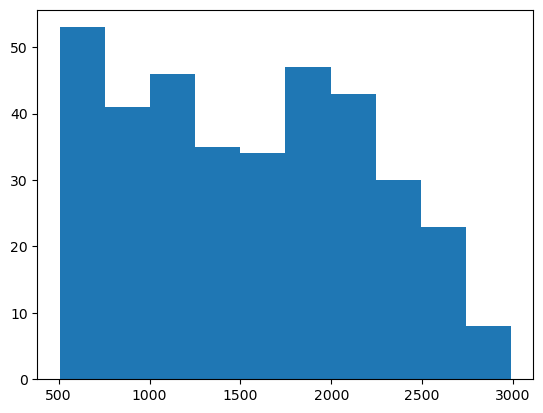

In [129]:
from matplotlib import pyplot as plt

plt.hist(p['total_minutes'])

In [119]:
row = podcast_df.iloc[5]
text = row.content
print(row)

find_coreferences_for_person(text, target_players)

12/07/2024 17:39:40 - INFO - 	 Tokenize 1 inputs...


publication_date                            2023-10-25 16:21:00+00:00
file_name           opening_night_takeaways_lebrons_workload_harde...
file_path           G:\My Drive\Columbia\Practical Deep Learning\F...
content             Welcome to a regular season edition, Brandon K...
duration                                                         3264
Name: 5, dtype: object


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

12/07/2024 17:39:40 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

{'lebron james': [" You know, we we've kinda want to to to have this plan in place for LeBron James to to have a limited workload during the regular season",
  ' He played 29 minutes last night, was notably, like, in and out of the game in in short stints',
  ' And even as the lakers were making a rally, you know, it felt like they were pretty hard line sticking to this stance that LeBron James was not going to play 30 minutes no matter what',
  ' I thought he looked great physically',
  " I I don't think LeBron James is going to average under 30 minutes this season",
  " This is like the 8th year in a row that whatever team he's on has said that they're managing his workload",
  " But as we saw last night, when LeBron's off the floor, the Lakers are not gonna win a lot of games",
  ' And as somebody who had, Lakers plus 5 quite confidently last night, every time they took him out, I was just cringing because this Lakers team would allow the Nuggets to just pour it on',
  " I don't thi

In [108]:
text.split(".")

['Welcome to a regular season edition, Brandon Kravitz, of the rotor wire fantasy basketball podcast',
 ' I am Nick Whalen joined as I always am on Wednesdays',
 ' It will be throughout the NBA season by Brandon Kravitz',
 ' Brandon, had a lot of fun previewing the season these last few weeks with you, but, man, it is great to have real NBA basketball back',
 " You know, like, the 1st week of the preseason, I've dialed in",
 " I'm watching every game",
 " I'm watching the condensed highlights, things like that",
 " But by the end of the preseason, you're just kinda ready for things to to have real meaning",
 ' And what a relief it was last night to to get Lakers nuggets in the early window and then, really fun game, a little bit of a sloppy game',
 ' Really, both of them were a bit sloppy between the Phoenix Suns and the Golden State Warriors',
 " But let's start with the LA Lakers",
 " You know, there's a a big outbreak of panic on fantasy basketball Twitter after this game when Darvi

In [21]:
text = podcast_df.iloc[0].content[:10000]
# people = ["LeBron James", "Stephen Curry", "Anthony Davis", "Trey Murphy", "Damian Lillard"]
people = ["Damian Lillard", "James Harden"]

# Find sentences containing references to each person
for person in people:
    coref_sentences = find_coreferences_for_person(text, person)
    print(f"\nSentences for {person}:")
    for sentence in coref_sentences:
        print(f"  - {sentence}")

12/07/2024 16:20:24 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

12/07/2024 16:20:24 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

12/07/2024 16:20:24 - INFO - 	 Tokenize 1 inputs...



Sentences for Damian Lillard:


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

12/07/2024 16:20:25 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]


Sentences for James Harden:
  -  I just saw a tweet, Brandon, indicating that James Harden is a no show at Sixers practice today
  -  Like, I I I don't really know what levers he's exactly trying to pull here
  -  You know, there there was some reporting, you know, unsourced or at least anonymously sourced yesterday, you know, that the the sixers are starting to canvas a little bit more aggressively as far as, you know, what a James Harden trade might look like, getting some other teams beyond the clippers involved
  -  I I I still think the most likely scenario given that we're 6 days away from opening night is that harden opens the season with the team, but I I I don't know if he's gonna be out there at opening night
  -  Like, I still think he'll be a member of the sixers, but do you do you expect him to play in their 1st game of the season? I don't so I've actually changed my tune on this the last couple of days
  -  I don't think he's gonna be on the team by the time this the the

In [23]:
t = " But I I I think Miami is content to to kinda sit back, play this out at least until, you know, midseason trade deadline, and that's, you know, when they would hopefully you know, another superstar shakes free and and potentially make their move after striking out on Damian Lillard"
# find_coreferences_for_person(text, "Damian Lillard")

resolved_doc = resolve_coreferences(t)

clusters = resolved_doc.get_clusters(as_strings=False)
cluster_texts = resolved_doc.get_clusters()

12/07/2024 16:36:53 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

12/07/2024 16:36:53 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
cluster_texts

[['I', 'I'], ['midseason trade deadline', 'that'], ['Miami', 'they', 'their']]

In [7]:
# Download NLTK data (for sentence tokenization)
nltk.download("punkt")
nltk.download("punkt_tab")

# Load SpaCy model for NER
nlp = spacy.load("en_core_web_sm")


# Define a function to clean text
def clean_text(text):
    """
    Removes irrelevant sections and prepares text for further processing.
    """
    # Remove advertisements or specific unwanted patterns
    ad_patterns = [
        r"(?i)sponsored by .*",  # Example: "Sponsored by XYZ"
        r"(?i)ad break.*",  # Example: "Ad break starts here"
        r"http\S+",  # URLs
        r"\[.*?\]",  # Content in brackets (e.g., [Music])
    ]
    for pattern in ad_patterns:
        text = re.sub(pattern, "", text)

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text



# Process all text files in a directory
def process_text_files(directory):
    """
    Processes all .txt files in the specified directory.
    Cleans text, segments it into sentences, and annotates entities.
    """
    results = []

    for file_name in os.listdir(directory):
        if file_name.endswith(".txt"):
            file_path = os.path.join(directory, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                text = f.read()

            # Clean text
            # cleaned_text = clean_text(text)

            # Segment text
            sentences = segment_by_semantics(text)

            # Annotate entities
            annotated_sentences = annotate_entities(sentences)

            # Save results
            results.extend(
                [
                    {
                        "file_name": file_name,
                        "sentence": ann["sentence"],
                        "word_count": len(ann["sentence"].split()),
                        "entities": ann["entities"],
                    }
                    for ann in annotated_sentences
                ]
            )
            break

    return results


def process_text_file(file_path: str):
    with open(file_path, "r", encoding="utf-8") as f:
        text = f.read()

    # Segment text
    sentences = segment_by_semantics(text)

    # Annotate entities
    annotated_sentences = annotate_entities(sentences)

    file_name = os.path.basename(file_path)

    # Save results
    results = [
        {
            "file_name": file_name,
            "sentence": ann["sentence"],
            "word_count": len(ann["sentence"].split()),
            "entities": ann["entities"],
        }
        for ann in annotated_sentences
    ]

    return results


# Directory containing text files
directory_path = "../data/raw/rotowire_2023_2024"

date = "2023-12-08"
file_path = (
    directory_path
    + "/Fantasy Basketball Waiver Wire - Adds for Week 8 2023-24_transcript_6b67bc46-0000-2bfc-bcc0-2405887bfb7c.txt"
)

results = process_text_file(file_path)

# Convert to a DataFrame for easy analysis
segment_df = pd.DataFrame(results)


current_season = get_nba_season(date)

minutes = player_util.player_minute_stats(current_season)
players = player_util.players_for_date(date)
players = players.merge(minutes, on=["personId", "personName"], how="left")

# players.sort_values(['games_over_5_minutes', 'avg_minutes_per_game'], ascending=False)
filtered_players = players[
    (players["games_over_5_minutes"] >= 10) & (players["avg_minutes_per_game"] >= 10)
]

print(len(players))
print(len(filtered_players))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Patrick\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Patrick\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


338
248


In [37]:
sentence = "".join([segment_df.iloc[i].sentence for i in [5, 6, 7]])
sentence

# TODO how can topic models be used?
# Hierarchical Dirichlet Process (HDP)
# Latent semantic Indexing (LSI or LDI)
# Latent Dirichlet Allocation (LDA)

"yeah Shannon we saw like I mentioned Trey Murphy was a team's highest score for the Pelicans he still coming off the bench though  any concerns about that or do you think like either still a good chance he ends up playing 30 minutes a game off the bench maybe the Pokemon starting lineup at some point you know her Jones is still in there right now  yeah I mean that that 43 to 17 third quarter by the Lakers basically makes last night's game you know absolutely and there's no reason to really there's no big takeaways from last night's game is Susan turned into a blowout you know nothing really matters what happened with the Pelicans from there so the 22 minutes that Murphy saw last night I'm not worried about like you said you still the leading scorer for 14 points in those 22 minutesand anytime you was on the floor he was very aggressive on the offensive end you know he's played 2230 and 22 minutes in the three games he's returned from injury having some rest kind of being East back int

In [39]:
import re

import nltk
from gensim.corpora.dictionary import Dictionary
from gensim.models import HdpModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK data
nltk.download("stopwords")
nltk.download("punkt")

# Define stopwords
stop_words = set(stopwords.words("english"))


# Preprocess the text
def preprocess_text(text):
    """
    Preprocess text by lowercasing, removing special characters,
    tokenizing, and removing stopwords.
    """
    # Lowercase the text
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r"[^a-z\s]", "", text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens


# File path to the podcast transcript
directory_path = "../data/raw/rotowire_2023_2024"
file_path = (
    directory_path
    + "/Fantasy Basketball Waiver Wire - Adds for Week 8 2023-24_transcript_6b67bc46-0000-2bfc-bcc0-2405887bfb7c.txt"
)

# Read and preprocess the text
# with open(file_path, "r", encoding="utf-8") as f:
#     text = f.read()

text = sentence
# Preprocess the text into tokenized segments
processed_text = preprocess_text(text)

# Segment the text into smaller chunks (e.g., paragraphs or 50-token chunks)
chunk_size = 50
chunks = [
    processed_text[i : i + chunk_size]
    for i in range(0, len(processed_text), chunk_size)
]

# Prepare the data for HDP
dictionary = Dictionary(chunks)
corpus = [dictionary.doc2bow(chunk) for chunk in chunks]

# Train the HDP model
hdp_model = HdpModel(corpus=corpus, id2word=dictionary)

# Print the discovered topics
topics = hdp_model.print_topics(num_topics=15, num_words=10)
for i, topic in enumerate(topics):
    print(f"Topic {i + 1}: {topic}")

Topic 1: (0, '0.033*inseason + 0.029*reason + 0.028*third + 0.027*teams + 0.025*injury + 0.024*right + 0.024*still + 0.022*herbert + 0.021*basically + 0.020*know')
Topic 2: (1, '0.046*said + 0.036*hit + 0.036*blowout + 0.029*herbert + 0.029*mentioned + 0.027*thats + 0.026*stick + 0.025*end + 0.023*theyre + 0.022*would')
Topic 3: (2, '0.048*champ + 0.040*rest + 0.036*yeah + 0.033*points + 0.027*hes + 0.026*blowout + 0.025*makes + 0.024*quarter + 0.021*ends + 0.020*mentioned')
Topic 4: (3, '0.063*blowout + 0.040*know + 0.035*absolutely + 0.034*well + 0.033*injury + 0.031*floor + 0.031*turned + 0.029*teams + 0.026*big + 0.024*reason')
Topic 5: (4, '0.064*said + 0.048*rotation + 0.043*stick + 0.036*night + 0.034*lakers + 0.030*quarter + 0.028*thats + 0.026*would + 0.025*three + 0.025*happened')
Topic 6: (5, '0.055*injury + 0.032*games + 0.031*leading + 0.027*stick + 0.026*happened + 0.026*alleviates + 0.022*yeah + 0.021*points + 0.021*pelicans + 0.021*minutes')
Topic 7: (6, '0.058*maybe + 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Patrick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Patrick\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [40]:
from gensim.models.coherencemodel import CoherenceModel

# Compute the coherence score
coherence_model = CoherenceModel(
    model=hdp_model, texts=chunks, dictionary=dictionary, coherence="c_v"
)
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")

Coherence Score: 0.2795729567203427


In [ ]:
# TODO better segmentation for better topic modeling?
# TODO look at topic distributions across documents
# TODO topic visualization in 2D space

# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Prepare the visualization
# vis_data = gensimvis.prepare(hdp_model, corpus, dictionary)
# pyLDAvis.display(vis_data)

## Pipeline

In [52]:
import numpy as np
import torch
from fastcoref import FCoref
from transformers import AutoModel, AutoTokenizer, pipeline

# Load the FastCoref model
coref_model = FCoref(model_name="biu-nlp/f-coref")

# Load a BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)


def get_players():
    # Replace with your logic to retrieve player names
    return {"LeBron James", "Stephen Curry", "Anthony Davis"}


def resolve_coreferences(text):
    """
    Resolves coreferences in the text using FastCoref.
    """
    doc = coref_model.predict(text, aggregation_strategy="average")
    resolved_text = doc.resolved_text
    return resolved_text


def extract_player_sentences(podcast_text, players):
    """
    Extracts sentences mentioning specific players using coreference resolution.
    """
    resolved_text = resolve_coreferences(podcast_text)
    sentences = resolved_text.split(". ")  # Simple sentence splitting

    player_sentences = {player: [] for player in players}

    for sentence in sentences:
        # Check if a player is mentioned directly in the sentence
        for player in players:
            if player in sentence:
                player_sentences[player].append(sentence.strip())

    return player_sentences


def generate_player_vectors(player_sentences):
    """
    Generate vector representations for each player using BERT.
    """
    player_vectors = {}

    for player, sentences in player_sentences.items():
        # Tokenize and process all sentences related to the player
        sentence_embeddings = []
        for sentence in sentences:
            inputs = tokenizer(
                sentence, return_tensors="pt", truncation=True, padding=True
            )
            with torch.no_grad():
                outputs = bert_model(**inputs)
                # Use [CLS] token embedding as the representation
                sentence_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0)
                sentence_embeddings.append(sentence_embedding.numpy())

        # Aggregate sentence embeddings for the player (mean pooling)
        if sentence_embeddings:
            player_vectors[player] = np.mean(sentence_embeddings, axis=0)
        else:
            player_vectors[player] = None  # No context found for the player

    return player_vectors


podcast_text = """
LeBron James played an incredible game last night, scoring 40 points. He showed great leadership on the court.
Meanwhile, Stephen Curry impressed everyone with his three-point shooting, hitting 7 threes.
Anthony Davis was solid on defense, but his offensive output was limited.
"""

# Retrieve players of interest
players = get_players()

# Extract sentences mentioning each player
player_sentences = extract_player_sentences(podcast_text, players)
print("Player Sentences:")
for player, sentences in player_sentences.items():
    print(f"{player}: {sentences}")

# Generate vector representations
player_vectors = generate_player_vectors(player_sentences)
print("\nPlayer Vectors:")
for player, vector in player_vectors.items():
    print(f"{player}: {vector}")

[autoreload of numpy.core.multiarray failed: Traceback (most recent call last):
  File "C:\Users\Patrick\anaconda3\envs\py310-ml-gpu\lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Patrick\anaconda3\envs\py310-ml-gpu\lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
  File "C:\Users\Patrick\anaconda3\envs\py310-ml-gpu\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "C:\Users\Patrick\anaconda3\envs\py310-ml-gpu\lib\site-packages\numpy\core\multiarray.py", line 1, in <module>
    from numpy._core import multiarray
  File "C:\Users\Patrick\anaconda3\envs\py310-ml-gpu\lib\site-packages\numpy\_core\mul

TypeError: FCoref.__init__() got an unexpected keyword argument 'model_name'

In [48]:
extract_player_sentences(text, get_players())

AttributeError: [E046] Can't retrieve unregistered extension attribute 'coref_clusters'. Did you forget to call the `set_extension` method?

## Bert Question Answering

In [41]:
# File path to the podcast transcript
directory_path = "../data/raw/rotowire_2023_2024"
file_path = (
    directory_path
    + "/Fantasy Basketball Waiver Wire - Adds for Week 8 2023-24_transcript_6b67bc46-0000-2bfc-bcc0-2405887bfb7c.txt"
)

# Read and preprocess the text
with open(file_path, "r", encoding="utf-8") as f:
    text = f.read()

In [45]:
from transformers import pipeline

# Load a QA pipeline
# qa_pipeline = pipeline("question-answering", model="deberta-v3-large")
qa_pipeline = pipeline(
    "question-answering", model="bert-large-uncased-whole-word-masking-finetuned-squad"
)

# Input context (podcast transcript)
# context = "LeBron James played exceptionally well last night, scoring 40 points. However, his defense was questionable..."
context = text

# Example questions
questions = [
    "What was said about Herbert Jones performance?",
    "What was the sentiment around Herbert Jones?",
    "Were there any criticisms of Herbert Jones?",
]

# Get answers for each question
for question in questions:
    result = qa_pipeline(question=question, context=context)
    print(f"Q: {question}\nA: {result['answer']}\n")

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Q: What was said about Herbert Jones performance?
A: the thing that disturbs me is he's not a young kid

Q: What was the sentiment around Herbert Jones?
A: he's not a young kid

Q: Were there any criticisms of Herbert Jones?
A: he's got two guys on the team that are better players than him



In [ ]:
# Alternative Approaches
# If the above adjustments still seem complex, consider alternative modeling approaches:

# 1. Use a Transformer-Based Model for End-to-End Analysis
# Models like GPT or BERT-based architectures can handle NER, context understanding, and sentiment analysis jointly.
# Fine-tune these models on annotated podcast text for:
# Identifying players
# Extracting context
# Classifying sentiment directly
# 2. Treat it as a Question-Answering Task
# Formulate the task as:
# "What is the sentiment around Player X in the podcast?"
# Use QA models to identify the most relevant segment and its sentiment.
# 3. Use Context-Aware Embedding Models
# Embed the entire podcast using a context-aware model like Sentence-BERT.
# Use similarity-based search to locate the most relevant context around a player mention and then analyze sentiment.

In [ ]:
# Improving Your Plan
# Instead of completely changing your plan, you can make it "smarter" and more manageable by addressing the key challenges strategically:

# 1. Named Entity Recognition (NER)
# Fine-tune or use a domain-specific model:

# Use pre-trained models like SpaCy or Hugging Face Transformers.
# Fine-tune these models on basketball-related text datasets (e.g., annotated transcripts, sports news, or player rosters).
# Incorporate a list of basketball player names:

# Use external data sources like NBA rosters or fantasy basketball datasets to build a lookup table for player names.
# Combine rule-based methods with NER:
# Check for matches between recognized entities and your roster list.
# Validate contextually by checking co-occurring terms like "team," "game," or "points."
# 2. Context Extraction
# Dynamic Window-Based Context:

# Extract a fixed-size window of text (e.g., N sentences or tokens) before and after the player mention.
# Experiment with window sizes to balance granularity and relevance.
# Semantic Segmentation:

# Use semantic chunking techniques (like segment_by_semantics) to split the text into coherent units.
# Identify the chunk containing the player's mention and analyze it.
# Dependency Parsing:

# Use syntactic dependency parsing to extract clauses or phrases related to the player’s name (e.g., actions or descriptors linked to the player).
# 3. Sentiment Analysis
# Fine-tune a Sentiment Model for Sports:

# Fine-tune a sentiment analysis model on basketball-specific text to handle domain-specific nuances like sarcasm or conditional praise.
# Example: Use Hugging Face models with labeled sentiment data from sports articles or social media.
# Aspect-Based Sentiment Analysis (ABSA):

# Train or use pre-built ABSA models to detect sentiment specifically related to the player.
# ABSA focuses on entities (e.g., players) and their associated sentiment directly.
# 4. Automate and Iterate
# Use a pipeline approach to combine NER, context extraction, and sentiment analysis:
# Perform NER to detect player mentions.
# Extract context dynamically using a combination of window-based and semantic chunking methods.
# Analyze sentiment on extracted context.
# Iteratively evaluate and refine the pipeline using test cases and manually annotated data.

In [20]:
sentence = "".join([segment_df.iloc[i].sentence for i in [5, 6, 7]])
sentence

"yeah Shannon we saw like I mentioned Trey Murphy was a team's highest score for the Pelicans he still coming off the bench though  any concerns about that or do you think like either still a good chance he ends up playing 30 minutes a game off the bench maybe the Pokemon starting lineup at some point you know her Jones is still in there right now  yeah I mean that that 43 to 17 third quarter by the Lakers basically makes last night's game you know absolutely and there's no reason to really there's no big takeaways from last night's game is Susan turned into a blowout you know nothing really matters what happened with the Pelicans from there so the 22 minutes that Murphy saw last night I'm not worried about like you said you still the leading scorer for 14 points in those 22 minutesand anytime you was on the floor he was very aggressive on the offensive end you know he's played 2230 and 22 minutes in the three games he's returned from injury having some rest kind of being East back int

In [31]:
import neuralcoref
import spacy

nlp = spacy.load("en_core_web_sm")

doc = nlp(sentence)
doc._.coref_resolved

ModuleNotFoundError: No module named 'neuralcoref'

In [28]:
annotated_sentence = annotate_entities([sentence])

In [29]:
annotated_sentence

[{'sentence': "yeah Shannon we saw like I mentioned Trey Murphy was a team's highest score for the Pelicans he still coming off the bench though  any concerns about that or do you think like either still a good chance he ends up playing 30 minutes a game off the bench maybe the Pokemon starting lineup at some point you know her Jones is still in there right now  yeah I mean that that 43 to 17 third quarter by the Lakers basically makes last night's game you know absolutely and there's no reason to really there's no big takeaways from last night's game is Susan turned into a blowout you know nothing really matters what happened with the Pelicans from there so the 22 minutes that Murphy saw last night I'm not worried about like you said you still the leading scorer for 14 points in those 22 minutesand anytime you was on the floor he was very aggressive on the offensive end you know he's played 2230 and 22 minutes in the three games he's returned from injury having some rest kind of being

In [25]:
# annotate_entities(segment_by_semantics(sentence)[0])

In [17]:
segment_df.iloc[6].sentence

"yeah I mean that that 43 to 17 third quarter by the Lakers basically makes last night's game you know absolutely and there's no reason to really there's no big takeaways from last night's game is Susan turned into a blowout you know nothing really matters what happened with the Pelicans from there so the 22 minutes that Murphy saw last night I'm not worried about like you said you still the leading scorer for 14 points in those 22 minutes"

In [16]:
segment_df.iloc[7].sentence

"and anytime you was on the floor he was very aggressive on the offensive end you know he's played 2230 and 22 minutes in the three games he's returned from injury having some rest kind of being East back into the rotation champ be a big surprise but the fact that he already hit 30 minutes basically alleviates any concerns I would have will he be in the starting lineup I think that's a bigger question mark I don't Herbert Herbert Jones been playing so well for the Pelicans that I think they're gonna stick with them for at least a little while I mean they're 12 and 11 they had some assess the in-season tournament"

In [ ]:
df.iloc[0].sentence

In [ ]:
df.iloc[0].sentence

In [ ]:
entities = df.iloc[0].entities